In [ ]:
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy

In [ ]:
from skimage import data
from skimage.feature import match_descriptors, plot_matches, SIFT, ORB
from skimage.color import rgb2gray
from skimage.measure import ransac
from skimage.transform import EuclideanTransform, warp
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/360_fisheye

/content/drive/MyDrive/360_fisheye


In [ ]:
image_folder = "/content/drive/MyDrive/360_fisheye/images_presentation/input/"
output_folder = '/content/drive/MyDrive/360_fisheye/images_presentation/output'

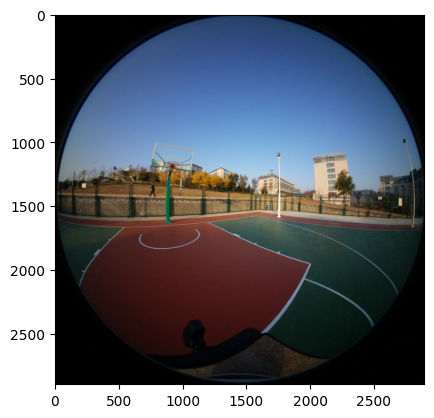

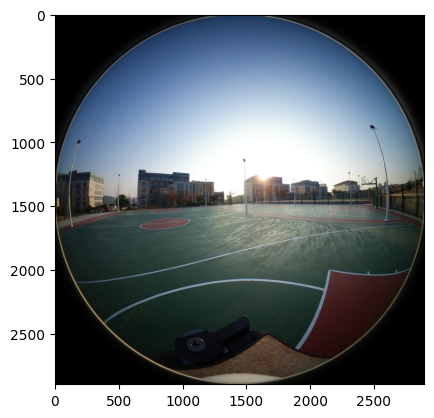

In [ ]:
evaluation_path = 'metric_evaluation/360_0770.JPG'
im = np.array(Image.open(evaluation_path))/255.
ima = im[:,:im.shape[1]//2]
imb = im[:,im.shape[1]//2:]


plt.imshow(ima)
plt.show()

plt.imshow(imb)
plt.show()

In [ ]:
def get_grid(im):
    h, w = im.shape[:2]
    x = np.arange(w)
    y = np.arange(h)
    x_prime = (2 * x / w - 1)
    y_prime = (2 * y / h - 1)
    grid1, grid2 = np.meshgrid(y_prime, x_prime)
    return grid1.ravel(), grid2.ravel()


def fisheye2d_to_vector3d(aperture, x, y):
    r = np.linalg.norm(np.stack([x, y]), axis=0)
    phi = r * (aperture*np.pi/180) / 2
    theta = np.arctan2(y, x)
    return r, phi, theta


def vector3d_to_latlon(r, phi, theta):
    P_y = r * np.cos(phi)
    P_z = r * np.sin(phi) * np.sin(theta)
    P_x = r * np.sin(phi) * np.cos(theta)
    longitude = np.arctan2(P_y, P_x)
    latitude = np.arctan2(P_z, np.sqrt(P_x**2 + P_y**2))
    return longitude, latitude


def latlon_to_equirectangular(longitude, latitude):
    x = longitude / np.pi
    y =  2 * latitude / np.pi
    x = ((x + 1) % 2) -1
    y = ((y + 1) % 2) -1
    return x, y


In [ ]:
aperture = 192.7
lambda_0 = -np.pi/2
y_grid, x_grid = get_grid(ima)


def compute_projection(aperture, y_grid, x_grid):
    r, phi, theta = fisheye2d_to_vector3d(aperture, y_grid, x_grid)
    ind = r<1
    longitude, latitude = vector3d_to_latlon(r[ind], phi[ind], theta[ind])
    longitude_a = longitude + lambda_0
    longitude_b = longitude - lambda_0

    equirectangular_x_a, equirectangular_y = latlon_to_equirectangular(longitude_a, latitude)
    equirectangular_x_b, equirectangular_y = latlon_to_equirectangular(longitude_b, latitude)

    return equirectangular_x_a, equirectangular_x_b, equirectangular_y, ind

equirectangular_x_a, equirectangular_x_b, equirectangular_y, ind = compute_projection(aperture, y_grid, x_grid)


In [ ]:
# Define output render grid size, here: resolution is y_sizex(y_size*3.6)px

# ysize/xsize should equal fov/360

y_size = 1600
x_size = y_size * 3.6
# x_size = (360/aperture) * y_size

# y_size = 1600
# x_size = y_size * 360/aperture
render_grid = tuple(np.mgrid[-1:1:complex(0, y_size), -1:1:complex(0, x_size)])
im_out_a = scipy.interpolate.griddata(
  np.stack([equirectangular_y, equirectangular_x_a]).T, ima.reshape(-1, 3)[ind], render_grid, method='nearest')

im_out_b = scipy.interpolate.griddata(
  np.stack([equirectangular_y, equirectangular_x_b]).T, imb.reshape(-1, 3)[ind], render_grid, method='nearest')

In [ ]:
x_size, y_size

(2989.1022314478464, 1600)

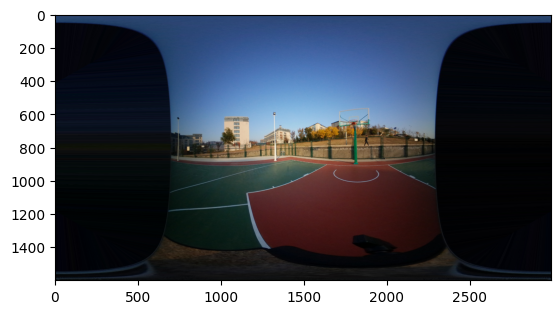

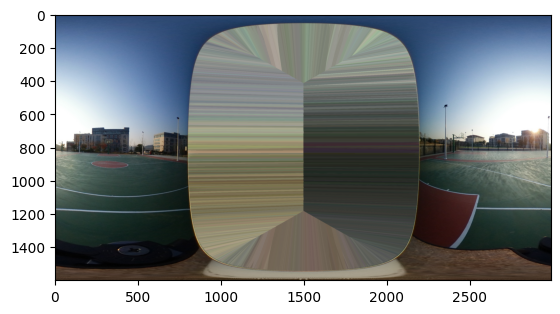

In [ ]:
plt.imshow(im_out_a)
plt.show()

plt.imshow(im_out_b)
plt.show()

In [ ]:
x_size = int(x_size)

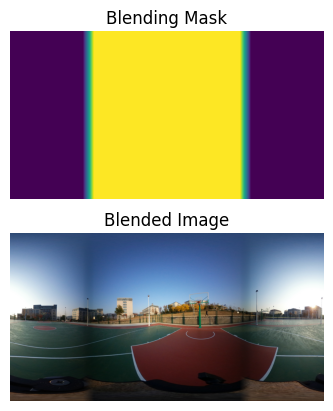

In [ ]:
# LINEAR BLENDING MASK

deg90 = (x_size/4)
deg270 = (3* x_size/4)
x_size = (x_size)

mask = np.ones_like(im_out_a[:,:,:1])

mask[:,:int(deg90-(aperture-180)//720)] = 0
mask[:,int(deg270+(aperture-180)//720):] = 0


mask[:,int(deg90-x_size * (aperture-180)/720):int(deg90+x_size * (aperture-180)/720)] = np.linspace(0, 1, int(x_size * (aperture-180)/360)).reshape(-1, 1)

mask[:,int(deg270-x_size * (aperture-180)/720):int(deg270+x_size * (aperture-180)/720)] = 1 - np.linspace(0, 1, int(x_size * (aperture-180)/360)).reshape(-1, 1)

fig, ax = plt.subplots(nrows=2)
ax[0].set_title("Blending Mask")
ax[0].axis('off')
ax[0].imshow(mask)
blended = (mask * im_out_a + (1 - mask) * im_out_b)
ax[1].set_title("Blended Image")
ax[1].axis('off')
ax[1].imshow(blended)



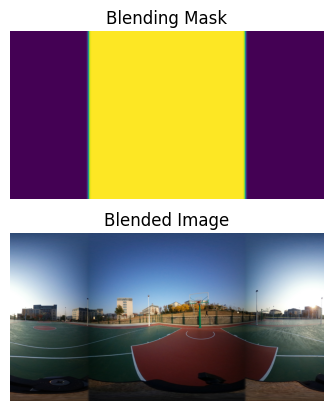

In [ ]:
# SIGMOID BLENDING MASK

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


deg90 = im_out_a.shape[1] // 4
deg270 = 3 * im_out_a.shape[1] // 4
x_size = im_out_a.shape[1]
aperture = 193

mask = np.ones_like(im_out_a[:, :, :1])

transition_width = int(x_size * (aperture - 180) / 360)
smoothness = 10

left_transition_start = int(deg90 - transition_width / 2)
left_transition_end = int(deg90 + transition_width / 2)
right_transition_start = int(deg270 - transition_width / 2)
right_transition_end = int(deg270 + transition_width / 2)

x_vals_left = np.linspace(-smoothness, smoothness, left_transition_end - left_transition_start)
x_vals_right = np.linspace(smoothness, -smoothness, right_transition_end - right_transition_start)

left_gradient = sigmoid(x_vals_left).reshape(1, -1)
right_gradient = sigmoid(x_vals_right).reshape(1, -1)

left_gradient = np.tile(left_gradient, (mask.shape[0], 1))
right_gradient = np.tile(right_gradient, (mask.shape[0], 1))

mask[:, left_transition_start:left_transition_end, 0] = left_gradient
mask[:, right_transition_start:right_transition_end, 0] = right_gradient

mask[:, :left_transition_start, :] = 0
mask[:, right_transition_end:, :] = 0

mask = np.clip(mask, 0, 1)

blended = mask * im_out_a + (1 - mask) * im_out_b

blended = mask * im_out_a + (1 - mask) * im_out_b
fig, ax = plt.subplots(nrows=2)
ax[0].set_title("Blending Mask")
ax[0].axis('off')
ax[0].imshow(mask)
blended = (mask * im_out_a + (1 - mask) * im_out_b)
ax[1].set_title("Blended Image")
ax[1].axis('off')
ax[1].imshow(blended)


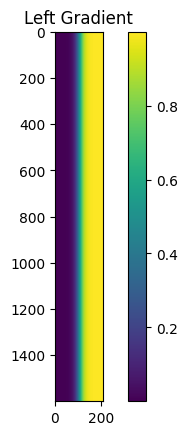

In [ ]:
plt.imshow(left_gradient, cmap='viridis')
plt.colorbar()
plt.title("Left Gradient")
plt.show()

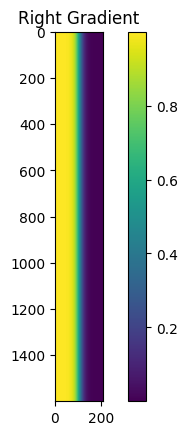

In [ ]:
plt.imshow(right_gradient, cmap='viridis')
plt.colorbar()
plt.title("Right Gradient")
plt.show()